In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Load CSV (daily data)
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "incidents_2000_daily.csv")
df_daily = pd.read_csv(downloads_path, parse_dates=['Date'])  # Parse Date as datetime
df_daily.set_index('Date', inplace=True)

# Aggregate to monthly (sum incidents per month)
df_monthly = df_daily.resample('MS').agg({
    'No.of Incidents': 'sum',
    'Client Owned': 'first',  # Or mode/mean if needed
    'Release Type': 'first',
    'Major Release Flag': 'first'
}).reset_index()
df_monthly.rename(columns={'Date': 'Month_Year'}, inplace=True)  # Now we have Month_Year
df_monthly['Month_Year'] = pd.to_datetime(df_monthly['Month_Year'])  # Ensure datetime

print(df_monthly.head())  # Should show monthly sums starting ~2015-01-01
df = df_monthly  # Use this for Prophet/ARIMA

# For ARIMAX: Load Excel separately if needed (already monthly)
# df_arimax = pd.read_excel('Time_Series_Data.xlsx', sheet_name='Raw Data', index_col='Month_Year', parse_dates=True)
# Use df_arimax below where noted

  Month_Year  No.of Incidents Client Owned Release Type  Major Release Flag
0 2015-01-01              312           No        Minor                   0
1 2015-02-01              140          Yes        Minor                   0
2 2015-03-01              181           No        Major                   1
3 2015-04-01              173          Yes        Minor                   0
4 2015-05-01              188          Yes        Minor                   0


658


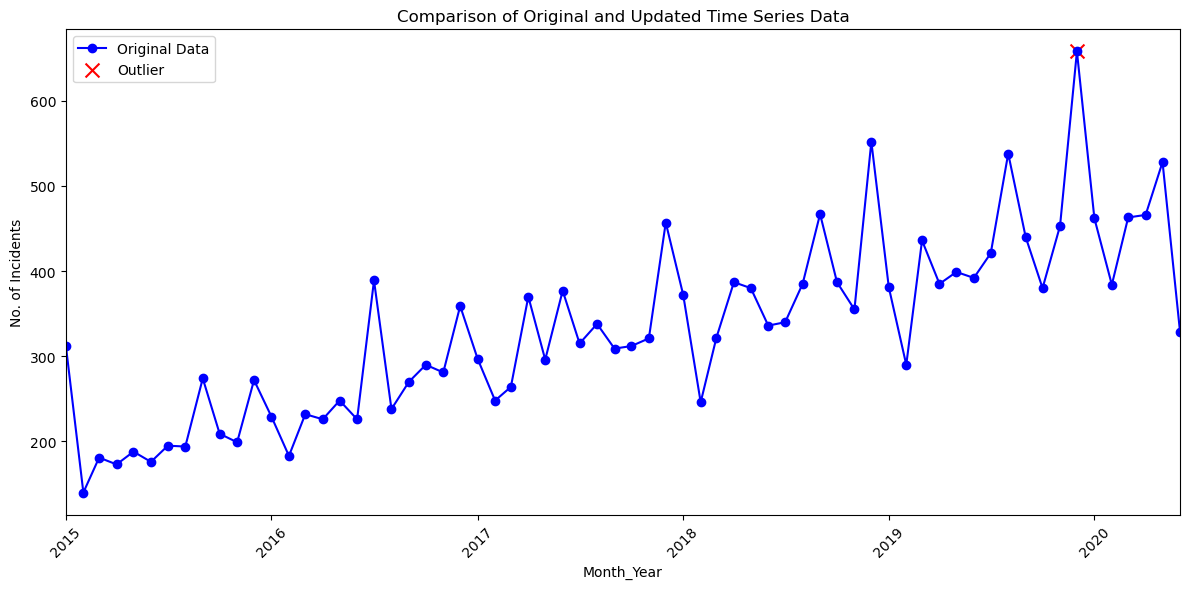

In [5]:
# Outlier detection (unchanged)
outlier_index = df['No.of Incidents'].idxmax()
df_old = df.copy()  # Good practice
max_value = df['No.of Incidents'].max()
# df.at[outlier_index, 'No.of Incidents'] = max_value / 1.3  # Uncomment to adjust

print(max_value)  # Or remove if not needed

# Plot (now uses 'Month_Year')
plt.figure(figsize=(12, 6))
plt.plot(df['Month_Year'], df['No.of Incidents'], label='Original Data', linestyle='-', marker='o', color='blue')
plt.scatter(df.loc[outlier_index, 'Month_Year'], df.loc[outlier_index, 'No.of Incidents'], 
            color='red', marker='x', s=100, label='Outlier')

# Fixed xlim
plt.xlim(df_old['Month_Year'].min(), df_old['Month_Year'].max())  # No min/max() needed; pandas handles datetimes
plt.title('Comparison of Original and Updated Time Series Data')
plt.xlabel('Month_Year')  # Add label for clarity
plt.ylabel('No. of Incidents')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-ticks if crowded
plt.tight_layout()  # Prevent cutoff
plt.show()

In [8]:
from prophet import Prophet  


train_size = int(len(df) * 0.84)  # 80% for training
train_df, test_df = df[:train_size], df[train_size:]


# In[ ]:


weekends_df = pd.DataFrame({
    'holiday': 'weekend',
    'ds': pd.date_range(start='2022-01-01', end='2023-12-31', freq='B'),  # B frequency for business days
    'lower_window': 0,
    'upper_window': 1,
})

# Mark Saturday and Sunday as holidays (1) and weekdays as non-holidays (0)
weekends_df['is_weekend'] = weekends_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)

# Filter only the rows where the day is a weekend
holidays_df = weekends_df[weekends_df['is_weekend'] == 1][['holiday', 'ds', 'lower_window', 'upper_window']]

In [9]:
# Rename columns to 'ds' and 'y'
train_df.rename(columns={'Month_Year': 'ds', 'No.of Incidents': 'y'}, inplace=True)

# Initialize Prophet model
model = Prophet(
changepoint_prior_scale=0.62,  
    yearly_seasonality=True,        
    weekly_seasonality=False,   
#     holidays=holidays_df,
    seasonality_mode='multiplicative' 
)

# Fit the model with the modified dataset
model.fit(train_df)

/var/folders/6v/5fzs84sd3c78pfkfjs42mfh40000gn/T/ipykernel_2432/708215225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'Month_Year': 'ds', 'No.of Incidents': 'y'}, inplace=True)
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Create a DataFrame with future dates for forecasting
future = model.make_future_dataframe(periods=len(test_df),freq='MS')  # Assuming you want to forecast 12 months ahead


# Make predictions for the future dates
forecast = model.predict(future)

/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


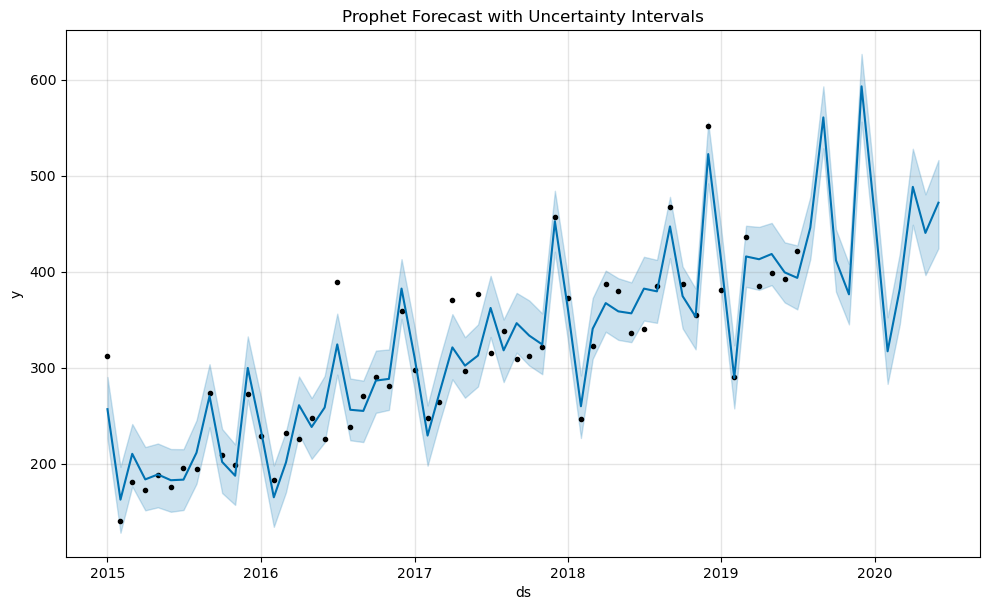

In [11]:
# Plot the forecast along with original data and uncertainty intervals
fig = model.plot(forecast)
plt.title('Prophet Forecast with Uncertainty Intervals')
plt.show()


/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

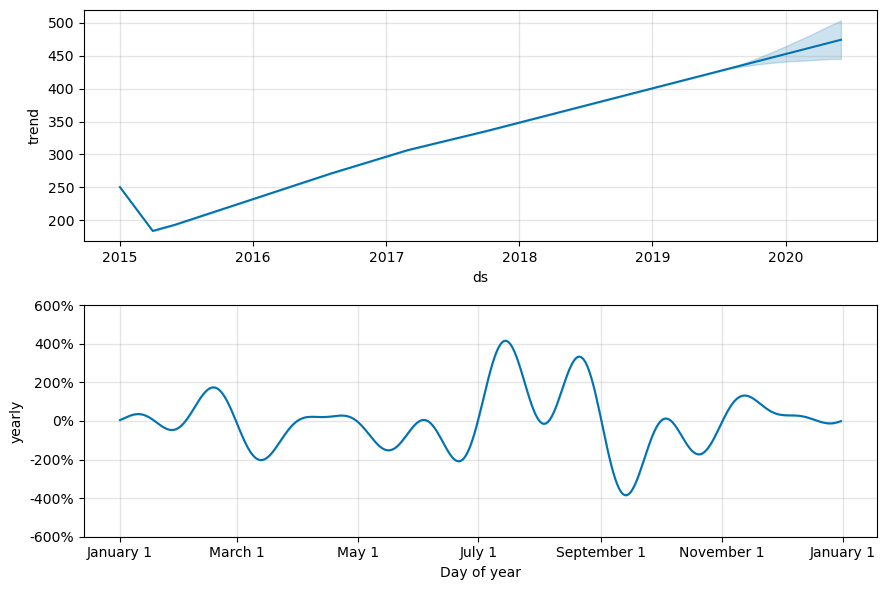

In [12]:
# Visualize the components of the forecast (trend, weekly, and yearly)
fig = model.plot_components(forecast)
plt.show()

In [13]:
# Extract actual and predicted values for the test period
test_df.rename(columns={'Month_Year': 'ds', 'No.of Incidents': 'y'}, inplace=True)

actual_values_test = test_df['y'].values
predicted_values_test = forecast['yhat'].values[-len(test_df):]

actual_values_train = train_df['y'].values
predicted_values_train = forecast['yhat'].values[-len(train_df):]

# Calculate MAPE on the test set
def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_test = calculate_mape(actual_values_test, predicted_values_test)

print(f'MAPE on the test set: {mape_test:.2f}%')

MAPE on the test set: 16.37%


/var/folders/6v/5fzs84sd3c78pfkfjs42mfh40000gn/T/ipykernel_2432/1437952441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'Month_Year': 'ds', 'No.of Incidents': 'y'}, inplace=True)


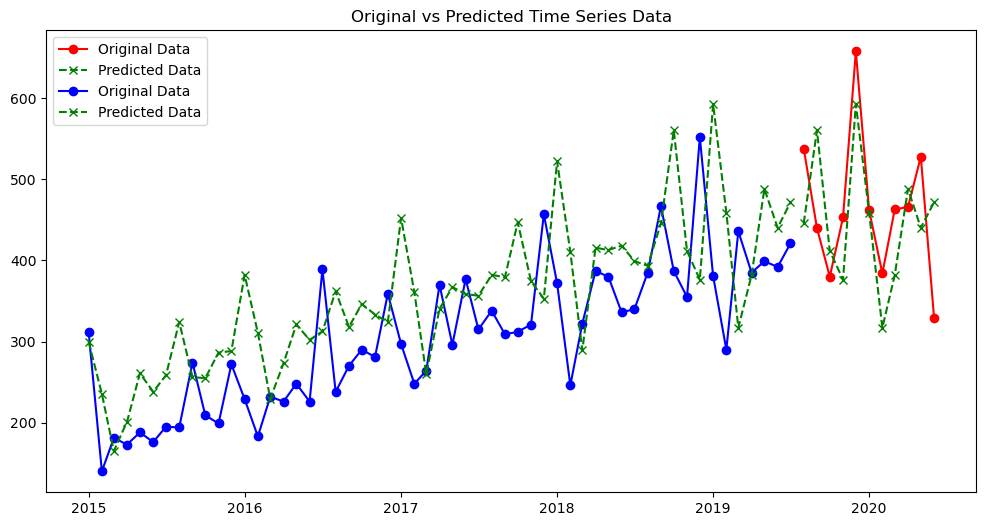

In [14]:
# Plot predicted vs original values
plt.figure(figsize=(12, 6))

plt.plot(test_df['ds'], actual_values_test, label='Original Data', linestyle='-', marker='o', color='red')
plt.plot(test_df['ds'], predicted_values_test, label='Predicted Data', linestyle='--', marker='x', color='green')

plt.plot(train_df['ds'], actual_values_train, label='Original Data', linestyle='-', marker='o', color='blue')
plt.plot(train_df['ds'], predicted_values_train, label='Predicted Data', linestyle='--', marker='x', color='green')

plt.title('Original vs Predicted Time Series Data')
plt.legend()
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA
def moving_average_arima(df, column, window):
    # Fit ARIMA model
    model = ARIMA(df[column], order=(1, 1, 1))  # ARIMA(0,0,0) corresponds to a simple moving average
    result = model.fit()

    # Get the fitted values
    fitted_values = result.fittedvalues

    # Calculate the moving average
    moving_average = fitted_values.rolling(window=window).mean()

    return moving_average,fitted_values



/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


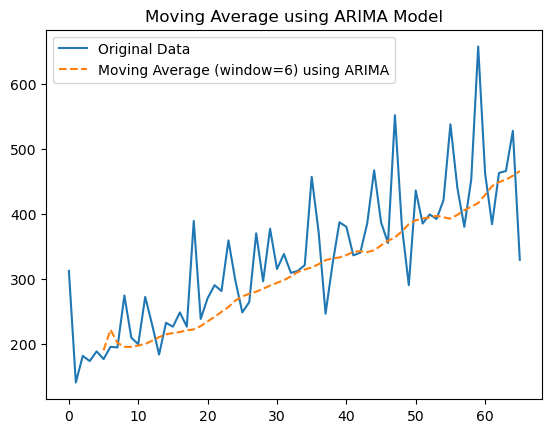

In [20]:
window_size=6
df['moving_avg_arima'],fitted_values = moving_average_arima(df, 'No.of Incidents', window_size)

# Plot the original data and the moving average
plt.plot(df['No.of Incidents'], label='Original Data')
plt.plot(df['moving_avg_arima'], label=f'Moving Average (window={window_size}) using ARIMA', linestyle='--')
plt.legend()
plt.title('Moving Average using ARIMA Model')
plt.show()



MAPE: 49.83%


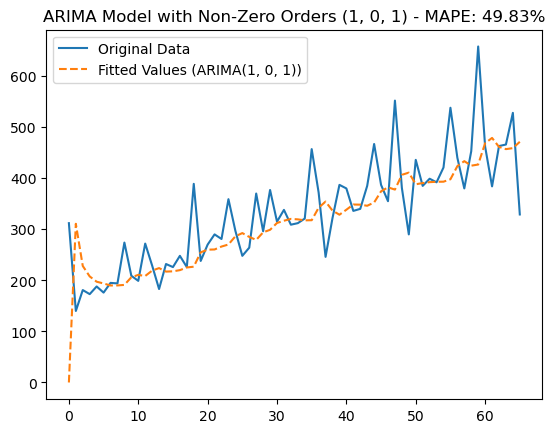

In [21]:
from sklearn.metrics import mean_absolute_error
mape_value = mean_absolute_error(df['No.of Incidents'], fitted_values)
print(f'MAPE: {mape_value:.2f}%')

order=(1, 0, 1)


# Plot the original data and the fitted values
plt.plot(df['No.of Incidents'], label='Original Data')
plt.plot(fitted_values, label=f'Fitted Values (ARIMA{order})', linestyle='--')
plt.legend()
plt.title(f'ARIMA Model with Non-Zero Orders {order} - MAPE: {mape_value:.2f}%')
plt.show()




In [22]:
# Train-test split
train_size = int(len(df) * 0.84)
train, test = df[:train_size].reset_index(drop=True), df[train_size:].reset_index(drop=True)

# Function to fit ARIMA model and calculate moving average
def moving_average_arima(train, test, column, window, order):
    # Concatenate train and test for simplicity
    combined = pd.concat([train, test], ignore_index=True)

    # Fit ARIMA model on the combined data
    model = ARIMA(combined[column], order=order)
    result = model.fit()

    # Get the fitted values on the combined data
    fitted_values_combined = result.fittedvalues

    # Calculate the moving average on the combined data
    moving_average_combined = fitted_values_combined.rolling(window=window).mean()

    # Split the results back into train and test
    moving_average_train = moving_average_combined.iloc[:len(train)]
    moving_average_test = moving_average_combined.iloc[len(train):]

    return moving_average_train, moving_average_test, result

window_size = 12
order = (1, 0, 1)

# Calculate moving averages for training and test sets
moving_avg_train, moving_avg_test, result = moving_average_arima(train, test, 'No.of Incidents', window_size, order)



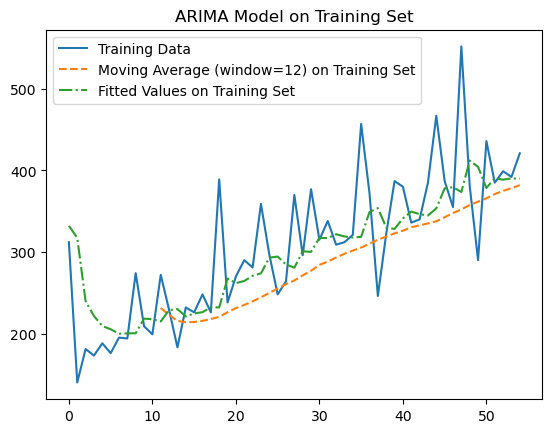

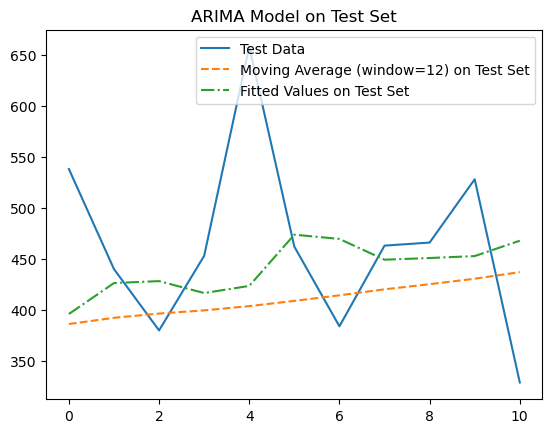

In [23]:
# Plot the original data, predicted values, and the moving averages on the training set
plt.plot(train['No.of Incidents'], label='Training Data')
plt.plot(moving_avg_train, label=f'Moving Average (window={window_size}) on Training Set', linestyle='--')
plt.plot(result.fittedvalues[:len(train)], label='Fitted Values on Training Set', linestyle='-.')
plt.legend()
plt.title('ARIMA Model on Training Set')
plt.show()

# Plot the original data, predicted values, and the moving averages on the test set
plt.plot(test.index, test['No.of Incidents'], label='Test Data')
plt.plot(test.index, moving_avg_test, label=f'Moving Average (window={window_size}) on Test Set', linestyle='--')
plt.plot(test.index, result.fittedvalues[len(train):], label='Fitted Values on Test Set', linestyle='-.')
plt.legend()
plt.title('ARIMA Model on Test Set')
plt.show()



In [24]:
# Calculate MAPE for the test set
mape_value_test = mean_absolute_error(test['No.of Incidents'], result.fittedvalues[len(train):])
print(f'MAPE on Test Set: {mape_value_test:.2f}%')

MAPE on Test Set: 74.09%


In [25]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test['No.of Incidents'],result.fittedvalues[len(train):])

result.fittedvalues[len(train):]


test['No.of Incidents']




0     538
1     440
2     380
3     453
4     658
5     462
6     384
7     463
8     466
9     528
10    329
Name: No.of Incidents, dtype: int64

##ARIMAX

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid

train_size = int(len(df) * 0.84)  # 80% for training
train_df, test_df = df[:train_size], df[train_size:]

In [32]:
ts_train = train_df[['No.of Incidents']]
ts_test = test_df[['No.of Incidents']]

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])


adf_test(ts_train)

ADF Statistic: -0.6625843456054741
p-value: 0.8562045092298385
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}


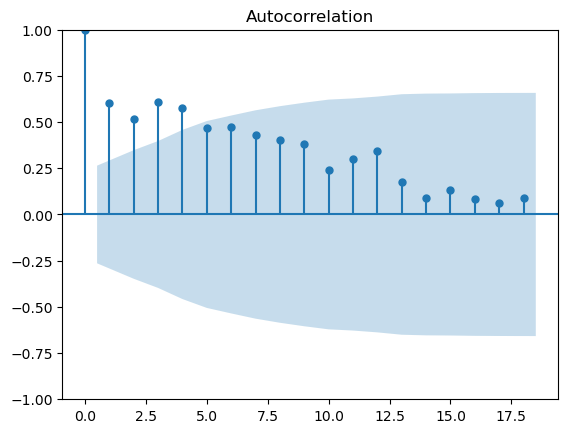

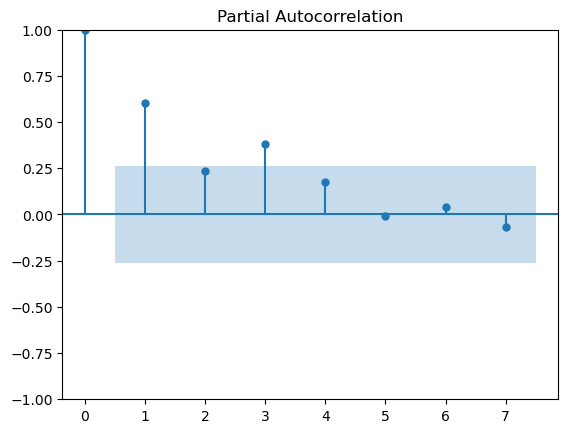

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plot_acf(ts_train)
plot_pacf(ts_train,lags=7)
plt.show()

In [48]:
exogenous_data = df[['Release Type']]
# #'Client Owned','Release Type','Major Release Flag'
exogenous_data.head()

encoded = pd.get_dummies(df[['Release Type']], prefix='category')

encoded
# encoded = pd.get_dummies(df[['Major Release Flag']], prefix='category')
# exogenous_data = pd.concat([exogenous_data, encoded], axis=1)


# df['Client Owned'] = df['Client Owned'].astype('category')


# encoded = pd.get_dummies(df[['Client Owned']], prefix='category')
# exogenous_data = pd.concat([exogenous_data, encoded], axis=1)


exogenous_data.head()

train_exogenous_data, test_exogenous_data = encoded[:train_size], encoded[train_size:]


In [42]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the parameter grid
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Grid search for ARIMA
best_aic = float("inf")
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal, exog=train_exogenous_data)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print('Best AIC:', best_aic)
print('Best Parameters:', best_params)

/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/prophet_

Best AIC: 595.1632767689644
Best Parameters: ((0, 1, 1), (1, 0, 1, 12))


/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/anaconda3/envs/prophet_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


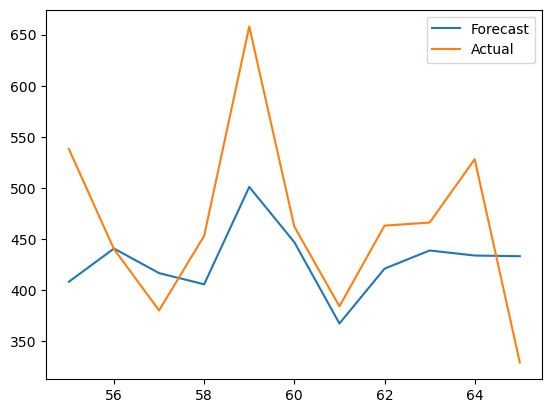

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit model
mod = SARIMAX(
    endog=ts_train,
    order=best_params[0],
    seasonal_order=best_params[1],
    exog=train_exogenous_data
)
results = mod.fit()

# Forecast
forecast_steps = len(test_exogenous_data)
forecast = results.get_forecast(steps=forecast_steps, exog=test_exogenous_data)
predicted_values = forecast.predicted_mean

# Plot
predicted_values.plot(label='Forecast')
ts_test['No.of Incidents'].plot(label='Actual')
plt.legend()
plt.show()


In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
mean_absolute_percentage_error(ts_test['No.of Incidents'],predicted_values)

12.760610271226167